# Emergency Vehicle Identification using CNN

In [17]:
#importing dependencies
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras import layers, models
from tensorflow.keras.applications import VGG16
from tensorflow.keras.models import Model
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from keras.callbacks import EarlyStopping, ModelCheckpoint
from keras.models import load_model
from sklearn.metrics import confusion_matrix, classification_report
import cv2
import os
import itertools

In [2]:
#image paths
train_path = 'images/train'
val_path = 'images/val'
test_path = 'images/test'

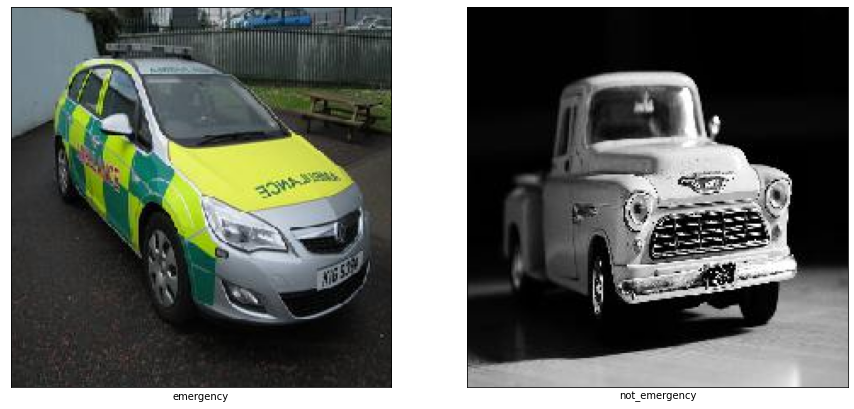

In [12]:
#view sample images
emergency_vehicle ='images/train/emergency/0.jpg'
not_emergency_vehicle = 'images/train/not_emergency/1002.jpg'

plt.rcParams["figure.figsize"] = (15,12)
for idx, path in enumerate([emergency_vehicle,not_emergency_vehicle]):
    img = cv2.imread(path)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    plt.subplot(1, 2, idx+1)
    plt.imshow(img, cmap=plt.cm.binary)
    plt.xlabel(path.split('/')[2])
    plt.grid(visible=None)
    plt.xticks([])
    plt.yticks([])

In [13]:
#image augmentation
train_datagen = ImageDataGenerator(
        rescale=1./255,
        shear_range=0.2,
        zoom_range=0.2,
        horizontal_flip=True)

test_datagen = ImageDataGenerator(rescale=1./255)

In [14]:
train_generator = train_datagen.flow_from_directory(
        directory=train_path,
        target_size=(150, 150),
        batch_size=32,
        class_mode='binary')

validation_generator = test_datagen.flow_from_directory(
        directory=val_path,
        target_size=(150, 150),
        batch_size=32,
        shuffle=False,
        class_mode='binary')

test_generator = test_datagen.flow_from_directory(
        directory=test_path,
        target_size=(200, 200),
        #batch_size=32,
        shuffle=False,
        class_mode=None)

Found 1646 images belonging to 2 classes.
Found 706 images belonging to 2 classes.
Found 0 images belonging to 0 classes.


In [15]:
train_generator.class_indices

{'emergency': 0, 'not_emergency': 1}

# Model Training

In [18]:
#Call back setup
mc = ModelCheckpoint(filepath='./base_model.h5',
                     monitor='accuracy',
                     verbose=1,
                     save_best_only=True)

es = EarlyStopping(monitor='accuracy',
                   min_delta=0.01,
                   patience=5,
                   verbose=1)
cb = [mc,es]

# Custom model

In [19]:
model = models.Sequential()
model.add(layers.Conv2D(32,(3,3),activation='relu', input_shape=(150,150,3)))
model.add(layers.MaxPooling2D((2,2)))
model.add(layers.Conv2D(64,(3,3),activation='relu'))
model.add(layers.MaxPooling2D((2,2)))
model.add(layers.Conv2D(64,(3,3),activation='relu'))
model.add(layers.Flatten())
model.add(layers.Dense(64, activation='relu'))
model.add(layers.Dense(2, activation='softmax'))

In [20]:
model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics='accuracy')

In [ ]:
history = model.fit(train_generator, steps_per_epoch=10, epochs=30, callbacks=cb)

Epoch 1/30
10/10 [==============================] - ETA: 0s - loss: 1.0102 - accuracy: 0.5688
Epoch 1: accuracy improved from -inf to 0.56875, saving model to .\base_model.h5
10/10 [==============================] - 17s 1s/step - loss: 1.0102 - accuracy: 0.5688
Epoch 2/30
10/10 [==============================] - ETA: 0s - loss: 0.6936 - accuracy: 0.5875
Epoch 2: accuracy improved from 0.56875 to 0.58750, saving model to .\base_model.h5


In [22]:
loss, accuracy = model.evaluate(validation_generator)
print(f'loss:{loss}')
print(f'accuracy:{accuracy}')

23/23 [==============================] - 5s 209ms/step - loss: 0.3983 - accuracy: 0.8314
loss:0.3983091711997986
accuracy:0.8314447402954102


# Transfer learning

In [6]:
vgg = VGG16(input_shape = (150,150,3), weights = 'imagenet', include_top = False)

for layer in vgg.layers:
    layer.trainable = False
    
x = layers.Flatten()(vgg.output)
x = layers.Dense(64, activation = 'relu')(x) 
x = layers.Dense(2, activation='softmax')(x)

model2 = Model(inputs = vgg.input, outputs = x)
model2.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics='accuracy')

In [10]:
model2.fit(train_generator,epochs=10,validation_data=validation_generator)

Epoch 1/10
52/52 [==============================] - 327s 6s/step - loss: 0.5493 - accuracy: 0.7467 - val_loss: 0.3104 - val_accuracy: 0.8754
Epoch 2/10
52/52 [==============================] - 296s 6s/step - loss: 0.3031 - accuracy: 0.8718 - val_loss: 0.3107 - val_accuracy: 0.8669
Epoch 3/10
52/52 [==============================] - 294s 6s/step - loss: 0.2656 - accuracy: 0.8852 - val_loss: 0.2373 - val_accuracy: 0.9093
Epoch 4/10
52/52 [==============================] - 295s 6s/step - loss: 0.2276 - accuracy: 0.9143 - val_loss: 0.3402 - val_accuracy: 0.8513
Epoch 5/10
52/52 [==============================] - 298s 6s/step - loss: 0.2200 - accuracy: 0.9101 - val_loss: 0.2085 - val_accuracy: 0.9249
Epoch 6/10
52/52 [==============================] - 296s 6s/step - loss: 0.1805 - accuracy: 0.9283 - val_loss: 0.1987 - val_accuracy: 0.9235
Epoch 7/10
52/52 [==============================] - 291s 6s/step - loss: 0.1874 - accuracy: 0.9198 - val_loss: 0.2084 - val_accuracy: 0.9122
Epoch 8/10
52

In [17]:
loss, accuracy = model2.evaluate(validation_generator)
print(f'loss:{loss}')
print(f'accuracy:{accuracy}')

23/23 [==============================] - 84s 4s/step - loss: 0.2121 - accuracy: 0.9249
loss:0.2121422290802002
accuracy:0.9249292016029358


# Model evaluation

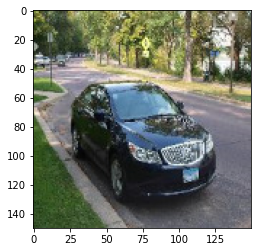

In [76]:
img = cv2.imread(r'images\bmw.jpg')
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
plt.imshow(img, cmap=plt.cm.binary)

In [77]:
type(img)

numpy.ndarray

In [78]:
labels = list(train_generator.class_indices.keys())
labels

['emergency', 'not_emergency']

In [88]:
prediction = model.predict(np.array([img])/255)
index = np.argmax(prediction)

In [91]:
vehicle_type =labels[index].replace('_',' ')
print(f'Vehicle is {vehicle_type}')

Vehicle is not emergency


In [15]:
#confusion matrix plot function 
def plot_confusion_matrix(cm, classes, normalize=False, title='Confusion Matrix', cmap=plt.cm.Blues):
    '''
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `noramlize=True`
    '''
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)
    
    if normalize:
        cm = cm.astype('float')/cm.sum(axis=1)[:, np.newaxis]
        print('Normalized confusion matrix')
    else:
        print('confusion matrix, without Normalized')
    
    print(cm)
    
    thresh = cm.max()/2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i,j],
                horizontalalignment='center',
                color='white' if cm[i,j] > thresh else 'black')
    
    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

In [83]:
predictions = model.predict(x=validation_generator, verbose=0)

In [84]:
predictions = np.argmax(predictions, axis=1)

In [86]:
cm =confusion_matrix(validation_generator.classes, predictions)

confusion matrix, without Normalized
[[229  81]
 [ 38 358]]


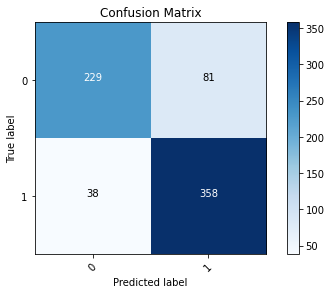

In [87]:
plot_confusion_matrix(cm=cm, classes=['0', '1'])

In [92]:
model.save('emergency_vehicle_recognition.h5')

In [94]:
model = load_model('emergency_vehicle_recognition.h5')

In [11]:
predictions2 = model2.predict(x=validation_generator, verbose=0)

In [12]:
predictions2 = np.argmax(predictions2, axis=1)

In [13]:
cm2 =confusion_matrix(validation_generator.classes, predictions2)

confusion matrix, without Normalized
[[296  14]
 [ 39 357]]


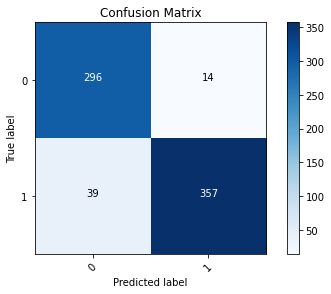

In [16]:
plot_confusion_matrix(cm=cm2, classes=['0', '1'])

In [19]:
model2.save('emergency_vehicle_recognition2.h5')